In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Dropout
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from tensorflow.keras.layers import Dropout
# Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python.
import matplotlib.pyplot as plt
import seaborn as sns 
# Split arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split

In [175]:
def minmax(file):
    d=pd.read_csv(file)
    d.drop(columns=["Unnamed: 0"],inplace=True)
    print(d.label.value_counts())

    d1=d.drop(columns=["length",'Type', 'timesensitive', 'client_min',
           'client_max', 'client_resendMin', 'client_resendMax', 'errorRate',
           'server_min', 'server_max', 'client_mac', 'client_ip',
           'client_send_port', 'client_rec_port', 'server_mac', 'server_ip',
           'server_send_port', 'server_rec_port'])

    packets_dum=pd.get_dummies(d1, columns=[ "session_id",'msg_type', 'iface_ver', 'proto_ver', 'retcode',
           'ip_src', 'ip_dst', 'proto', 'sport', 'dport', 'mac_src', 'mac_dst',
           'service_id', 'method_id','Client_id'])


    #packets_dum.drop(columns=["iface_ver_3","retcode_10","ip_src_10.1.0.9","mac_src_02:9b:bb:bb:bb:bb"],inplace=True)

    packets_dum["Label"]=packets_dum["label"]

    packets_dum.drop(columns="label",inplace=True)
    packets_dum.head()

    X=packets_dum.iloc[:,0:-1]
    y=packets_dum.iloc[:,-1]

    X=X.astype(float)
    X=X.to_numpy()
    y=y.astype(int)
    y=y.to_numpy()

    print(X.shape)

    window=8
    X_new=np.zeros((X.shape[0],window*2+1,X.shape[1]))
    X_new.shape

    for i in range(len(X_new)):
        if(i-window<0):
            X_new[i]=np.concatenate((np.zeros((abs(i-window),X_new.shape[2])),X[0:i+window+1]))
        else:
            if(((i-window)>=0) & ((i+window)<=len(X)-1)):
                X_new[i]=X[i-window:i+window+1]
            else:
                X_new[i]=np.concatenate((X[(i-window):len(X)],np.zeros(((i+window-len(X)+1),X_new.shape[2]))))

    y_new=y


    index_minority=np.where(y_new==1)

    count=0
    X_minority=np.zeros((len(np.where(y_new==1)[0]),X_new.shape[1],X_new.shape[2]))
    for i in index_minority[0]:
        X_minority[count]=X_new[i]
        count+=1

    index_majority=np.where(y_new==0)

    count=0
    X_majority=np.zeros((len(np.where(y_new==0)[0]),X_new.shape[1],X_new.shape[2]))
    for i in index_majority[0]:
        X_majority[count]=X_new[i]
        count+=1



    #print(X1_minority)

    #print(X1_majority)

    #Xmax=resample(X1_majority,replace=False,n_samples=len(X1_minority),random_state=123)


    return X_minority,X_majority

In [176]:
Xmin1,Xmax1=minmax("missing_request3.csv")

0    1280
1      94
Name: label, dtype: int64
(1374, 195)


In [177]:
Xmin2,Xmax2=minmax("missing_request4.csv")

0    1248
1     121
Name: label, dtype: int64
(1369, 195)


In [178]:
Xmin3,Xmax3=minmax("missing_request5.csv")

0    1318
1      93
Name: label, dtype: int64
(1411, 195)


In [179]:
Xmin4,Xmax4=minmax("missing_request6.csv")

0    1228
1     110
Name: label, dtype: int64
(1338, 195)


In [180]:
Xmin5,Xmax5=minmax("missing_request7.csv")

0    1240
1     109
Name: label, dtype: int64
(1349, 195)


In [181]:
Xmin6,Xmax6=minmax("missing_request8.csv")

0    1250
1     122
Name: label, dtype: int64
(1372, 195)


In [182]:
Xmin7,Xmax7=minmax("missing_request9.csv")

0    1274
1     118
Name: label, dtype: int64
(1392, 195)


In [183]:
Xmin8,Xmax8=minmax("missing_request10.csv")

0    1226
1     110
Name: label, dtype: int64
(1336, 195)


In [184]:
X_abnormal=np.concatenate((Xmin1,Xmin2,Xmin3,Xmin4,Xmin5,Xmin6,Xmin7,Xmin8))
Y_abnormal=np.ones((len(X_abnormal),1))

X_normal=np.concatenate((Xmax1,Xmax2,Xmax3,Xmax4,Xmax5,Xmax6,Xmax7,Xmax8))
#X_normal=resample(Xmax,replace=False,n_samples=len(X_abnormal),random_state=10)

#X_total=np.concatenate((X_normal,X_abnormal),axis=0)
#Y_total=np.concatenate((np.zeros((len(X_normal),1)),np.ones((len(X_abnormal),1))))

X_total=np.concatenate((X_normal,X_abnormal),axis=0)
Y_total=np.concatenate((np.zeros((len(X_normal),1)),np.ones((len(X_abnormal),1))))

In [199]:
import pickle 

with open('X_total.pickle', 'wb') as f:
    pickle.dump(X_total, f)
with open('Y_total.pickle', 'wb') as f:
    pickle.dump(Y_total, f)

In [200]:
Y_total.shape

(10941, 1)

In [201]:
len(X_abnormal)/(len(X_total))*100

8.015720683666942

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_total, Y_total, test_size=0.1, random_state=42,stratify=Y_total)
import random as rn 


model=tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128,input_shape=[X_train.shape[1],X_train.shape[2]],return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1,activation="sigmoid"))
model.compile(loss='binary_crossentropy',optimizer='adam')
model.fit(X_train,y_train,epochs=10,batch_size=30,validation_data=(X_test,y_test))

# Multiclass
y_pred = model.predict_classes(X_test)
cm=confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)    
disp.plot() 

# Multiclass
y_pred = model.predict_classes(X_train)
cm=confusion_matrix(y_train, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)    
disp.plot() 

In [187]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / len(X_normal)) * (len(X_total) / 2.0)
weight_for_1 = (1 / len(X_abnormal)) * (len(X_total) / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.54
Weight for class 1: 6.24


In [188]:
from tensorflow import keras

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

Epoch 1/100
5/5 [==============================] - 6s 1s/step - loss: 0.7029 - tp: 373.0000 - fp: 4101.0000 - tn: 5085.0000 - fn: 425.0000 - accuracy: 0.5467 - precision: 0.0834 - recall: 0.4674 - auc: 0.5309 - prc: 0.0877 - val_loss: 0.5515 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1007.0000 - val_fn: 88.0000 - val_accuracy: 0.9196 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6593 - val_prc: 0.1408
Epoch 2/100
5/5 [==============================] - 4s 879ms/step - loss: 0.6872 - tp: 287.0000 - fp: 2390.0000 - tn: 6667.0000 - fn: 502.0000 - accuracy: 0.7063 - precision: 0.1072 - recall: 0.3638 - auc: 0.5688 - prc: 0.1004 - val_loss: 0.7868 - val_tp: 87.0000 - val_fp: 914.0000 - val_tn: 93.0000 - val_fn: 1.0000 - val_accuracy: 0.1644 - val_precision: 0.0869 - val_recall: 0.9886 - val_auc: 0.6573 - val_prc: 0.1391
Epoch 3/100
5/5 [==============================] - 4s 853ms/step - loss: 0.6804 - tp: 672.0000 - fp: 6402.0000 - tn: 2655.0000 - fn: 117.0000 - a

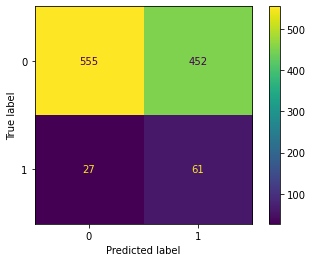

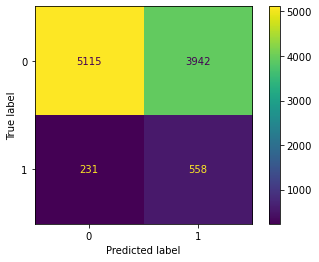

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X_total, Y_total, test_size=0.1, random_state=42,stratify=Y_total)
import random as rn 


model=tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256,input_shape=[X_train.shape[1],X_train.shape[2]],return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1,activation="sigmoid"))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=METRICS)
model.fit(X_train,y_train,epochs=100,batch_size=2048,validation_data=(X_test,y_test), class_weight=class_weight,  callbacks=[early_stopping])

# Multiclass
y_pred = model.predict_classes(X_test)
cm=confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)    
disp.plot() 

# Multiclass
y_pred = model.predict_classes(X_train)
cm=confusion_matrix(y_train, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)    
disp.plot() 

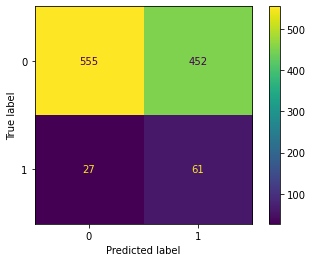

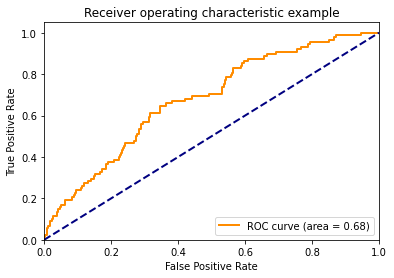

In [210]:
from sklearn.metrics import roc_curve, auc

# Multiclass
y_pred = model.predict_classes(X_test)
cm=confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)    
disp.plot() 


y_score=model.predict(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

    

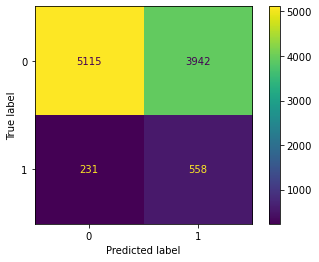

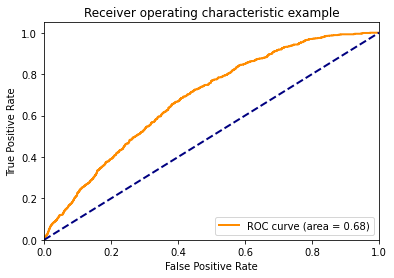

In [211]:
from sklearn.metrics import roc_curve, auc

# Multiclass
y_pred = model.predict_classes(X_train)
cm=confusion_matrix(y_train, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)    
disp.plot() 


y_score=model.predict(X_train)

fpr, tpr, _ = roc_curve(y_train, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

    

In [212]:
def data(file):
    d=pd.read_csv(file)
    d.drop(columns=["Unnamed: 0"],inplace=True)
    print(d.label.value_counts())

    d1=d.drop(columns=["length",'Type', 'timesensitive', 'client_min',
           'client_max', 'client_resendMin', 'client_resendMax', 'errorRate',
           'server_min', 'server_max', 'client_mac', 'client_ip',
           'client_send_port', 'client_rec_port', 'server_mac', 'server_ip',
           'server_send_port', 'server_rec_port'])

    packets_dum=pd.get_dummies(d1, columns=[ "session_id",'msg_type', 'iface_ver', 'proto_ver', 'retcode',
           'ip_src', 'ip_dst', 'proto', 'sport', 'dport', 'mac_src', 'mac_dst',
           'service_id', 'method_id','Client_id'])


    #packets_dum.drop(columns=["iface_ver_3","retcode_10","ip_src_10.1.0.9","mac_src_02:9b:bb:bb:bb:bb"],inplace=True)

    packets_dum["Label"]=packets_dum["label"]

    packets_dum.drop(columns="label",inplace=True)
    packets_dum.head()

    X=packets_dum.iloc[:,0:-1]
    y=packets_dum.iloc[:,-1]

    X=X.astype(float)
    X=X.to_numpy()
    y=y.astype(int)
    y=y.to_numpy()

    print(X.shape)

    window=8
    X_new=np.zeros((X.shape[0],window*2+1,X.shape[1]))
    X_new.shape

    for i in range(len(X_new)):
        if(i-window<0):
            X_new[i]=np.concatenate((np.zeros((abs(i-window),X_new.shape[2])),X[0:i+window+1]))
        else:
            if(((i-window)>=0) & ((i+window)<=len(X)-1)):
                X_new[i]=X[i-window:i+window+1]
            else:
                X_new[i]=np.concatenate((X[(i-window):len(X)],np.zeros(((i+window-len(X)+1),X_new.shape[2]))))

    y_new=y


    

    return X_new,y_new

In [213]:
X,y=data("missing_request_test.csv")

0    1292
1     115
Name: label, dtype: int64
(1407, 195)


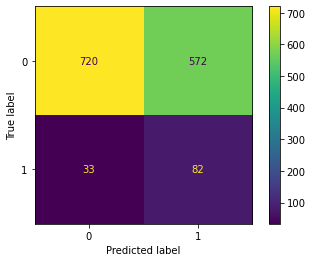

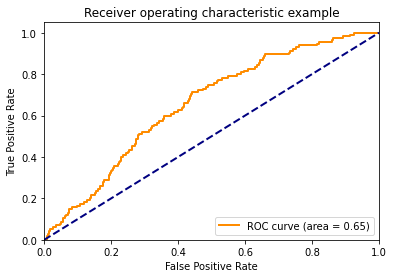

In [214]:
# Multiclass
y_pred = model.predict_classes(X)
cm=confusion_matrix(y, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)    
disp.plot() 


y_score=model.predict(X)

fpr, tpr, _ = roc_curve(y, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()    